<a href="https://colab.research.google.com/github/mahdiimanzadeh/Anomaly-Detection-MNIST/blob/main/Anomaly_Detection_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [41]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [42]:
import pandas as pd
df = pd.read_csv('/content/drive/My Drive/mnist_with_anomalies.csv')

In [43]:
df.head()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [44]:
df.shape

(6963, 784)

In [45]:
anomaly_indices = [2658, 2609, 2597, 863, 790, 712, 701, 663, 401, 352, 329, 223, 143, 81,
                   6857, 6535, 6235, 6229, 6065, 3295, 3203, 3093, 2781, 2765, 2726, 2704]

In [46]:
import numpy as np

df = df.astype(np.float32) / 255.0
x_train = np.delete(df, anomaly_indices, axis=0)

In [47]:
df.loc[2658]

,2658
pixel1,0.0
pixel2,0.0
pixel3,0.0
pixel4,0.0
pixel5,0.0
...,...
pixel780,0.0
pixel781,0.0
pixel782,0.0
pixel783,0.0


In [48]:
x_test = df.loc[anomaly_indices]

In [49]:
np.ones(len(x_test))

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1.])

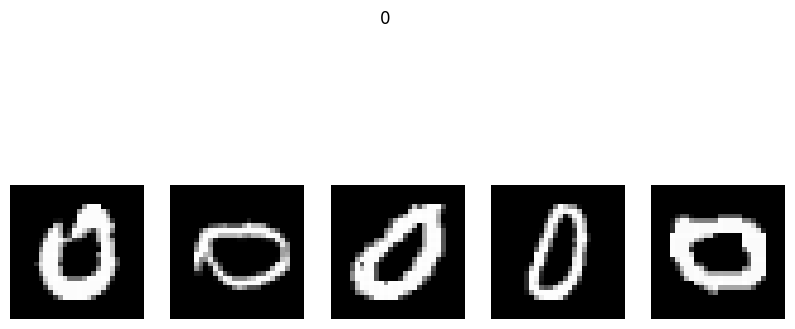

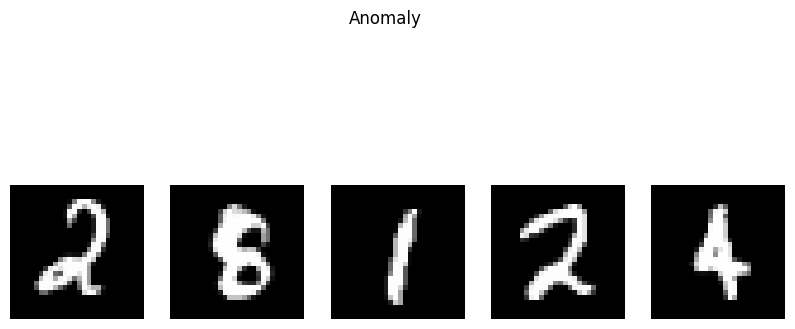

In [50]:
import matplotlib.pyplot as plt

# نمایش چند نمونه از داده‌های نرمال
plt.figure(figsize=(10, 5))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(x_train[i].reshape(28, 28), cmap='gray')
    plt.axis('off')
plt.suptitle("0")
plt.show()

# نمایش چند نمونه از داده‌های آنومالی
plt.figure(figsize=(10, 5))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(x_test.iloc[i].values.reshape(28, 28), cmap='gray')
    plt.axis('off')
plt.suptitle("Anomaly")
plt.show()


# Evaluation

In [51]:
from sklearn.metrics import accuracy_score

def evaluate_performance(true_labels, predictions, normal_data_errors, threshold):
    """
    Evaluate the performance of an anomaly detection method.

    Parameters:
    - true_labels: Ground truth labels (1 for anomaly, 0 for normal).
    - predictions: Predicted labels (1 for anomaly, 0 for normal).
    - normal_data_errors: Reconstruction errors or log-likelihood scores for normal data.
    - threshold: Threshold for classifying anomalies.

    Returns:
    - accuracy: Percentage of correctly classified anomalies.
    - false_positive_rate: Percentage of normal data incorrectly classified as anomalies.
    """
    # Calculate accuracy
    accuracy = accuracy_score(true_labels, predictions)

    # Calculate false positives
    false_positives = np.sum(normal_data_errors > threshold)
    false_positive_rate = false_positives / len(normal_data_errors)

    return accuracy, false_positive_rate

# Autoencoder

## Define encoder


In [52]:
from tensorflow.keras import layers, models

input_img = layers.Input(shape=(x_train.shape[1],)) # Input Layer

## hidden layers

In [53]:
encoded = layers.Dense(200, activation='relu')(input_img) # first hidden layer
encoded = layers.Dense(100, activation='relu')(encoded) # second hidden layer
encoded = layers.Dense(50, activation='relu')(encoded) # third hidden layer

In [54]:
bottleneck = layers.Dense(25, activation='relu')(encoded)
encoder = models.Model(input_img,bottleneck,name='encoder')

## Define decoder


In [55]:
decoded = layers.Dense(50, activation='relu')(bottleneck) #first hidden layer
decoded = layers.Dense(100, activation='relu')(decoded) #second hidden layer
decoded = layers.Dense(200, activation='relu')(decoded) #third hidden layer
decoded = layers.Dense(x_train.shape[1],activation='sigmoid')(decoded) #output layer
decoder = models.Model(bottleneck, decoded, name='decoder')

## Define autoencoder


In [56]:
autoencoder_input = layers.Input(shape=(x_train.shape[1],)) # input layer
encoded_repr = encoder(autoencoder_input) # encoder output
decoded_output = decoder(encoded_repr) # decoder output
autoencoder = models.Model(autoencoder_input, decoded_output, name='autoencoder')  ## Autoencoder model
autoencoder.compile(optimizer='adam',loss='mse')  # Compile model with Adam optimizer and MSE loss

## Train autoencoder


In [17]:
autoencoder.fit(x_train,x_train, epochs=40, batch_size=256, validation_data=(x_test, x_test))

Epoch 1/40
28/28 ━━━━━━━━━━━━━━━━━━━━ 7s 96ms/step - loss: 0.1596 - val_loss: 0.1103
Epoch 2/40
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0660 - val_loss: 0.1034
Epoch 3/40
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0590 - val_loss: 0.0945
Epoch 4/40
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0459 - val_loss: 0.0859
Epoch 5/40
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0395 - val_loss: 0.0782
Epoch 6/40
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0373 - val_loss: 0.0757
Epoch 7/40
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0344 - val_loss: 0.0725
Epoch 8/40
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0312 - val_loss: 0.0730
Epoch 9/40
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0284 - val_loss: 0.0698
Epoch 10/40
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0261 - val_loss: 0.0690
Epoch 11/40
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0251 - val_loss: 0.0671
Epoch 12/40
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0239 - val_l

## Calculate reconstruction loss


In [18]:
def calculate_reconstruction_loss(data,model):
  reconstructions = model.predict(data)  # Get model predictions
  reconstruction_errors = np.mean(np.abs(data - reconstructions), axis =1) # Compute mean absolute error
  return reconstruction_errors

## Evaluate the model


In [19]:
reconstruction_loss_normal = calculate_reconstruction_loss(x_train, autoencoder)
reconstruction_loss_anomalous = calculate_reconstruction_loss(x_test, autoencoder)

217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step


## Print average reconstruction loss


In [20]:
print(f"Average Reconstruction Loss for Normal Data: {np.mean(reconstruction_loss_normal)}")
print(f"Average Reconstruction Loss for Anomalous Data: {np.mean(reconstruction_loss_anomalous)}")


Average Reconstruction Loss for Normal Data: 0.04043365812996419
Average Reconstruction Loss for Anomalous Data: 0.1094483712918833


## Visualization of reconstruction error distribution


In [21]:
import matplotlib.pyplot as plt

# Set threshold (e.g., 95th percentile of normal data errors)
threshold_autoencoder = np.percentile(reconstruction_loss_normal, 97)
autoencoder_pred = reconstruction_loss_anomalous> threshold_autoencoder

accuracy_autoencoder, fpr_autoencoder = evaluate_performance(
    true_labels=np.ones(len(x_test)),  # All test samples are anomalies
    predictions=autoencoder_pred,
    normal_data_errors=reconstruction_loss_normal,
    threshold=threshold_autoencoder
)

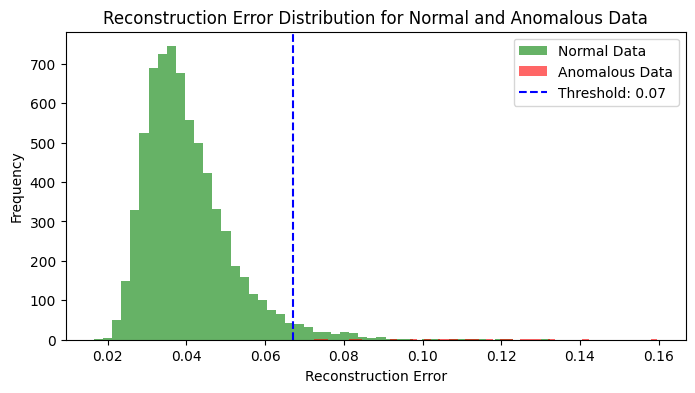

In [22]:
# Plot the distribution of reconstruction errors
plt.figure(figsize=(8, 4))
plt.hist(reconstruction_loss_normal, bins=50, alpha=0.6, color='g', label='Normal Data')
plt.hist(reconstruction_loss_anomalous, bins=50, alpha=0.6, color='r', label='Anomalous Data')
plt.axvline(threshold_autoencoder, color='b', linestyle='--', label=f'Threshold: {threshold_autoencoder:.2f}')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.title('Reconstruction Error Distribution for Normal and Anomalous Data')
plt.legend()
plt.show()

In [23]:
# Calculate 95th and 97th percentile thresholds
threshold_95 = np.percentile(reconstruction_loss_normal, 95)
threshold_97 = np.percentile(reconstruction_loss_normal, 97)

# Evaluate false positives and accuracy for each threshold
for threshold, percentile in zip([threshold_95, threshold_97], [95, 97]):
    autoencoder_pred = reconstruction_loss_anomalous > threshold
    accuracy = np.sum(autoencoder_pred) / len(autoencoder_pred)
    false_positives = np.sum(reconstruction_loss_normal > threshold)
    false_positive_rate = false_positives / len(reconstruction_loss_normal)

    print(f"Threshold ({percentile}th percentile): {threshold:.4f}")
    print(f"Accuracy: {accuracy:.2f}")
    print(f"False Positives: {false_positives} out of {len(reconstruction_loss_normal)}")
    print(f"False Positive Rate: {false_positive_rate:.4f}")
    print("------")

Threshold (95th percentile): 0.0617
Accuracy: 1.00
False Positives: 347 out of 6937
False Positive Rate: 0.0500
------
Threshold (97th percentile): 0.0672
Accuracy: 1.00
False Positives: 209 out of 6937
False Positive Rate: 0.0301
------


### 97th percentile is optimal one

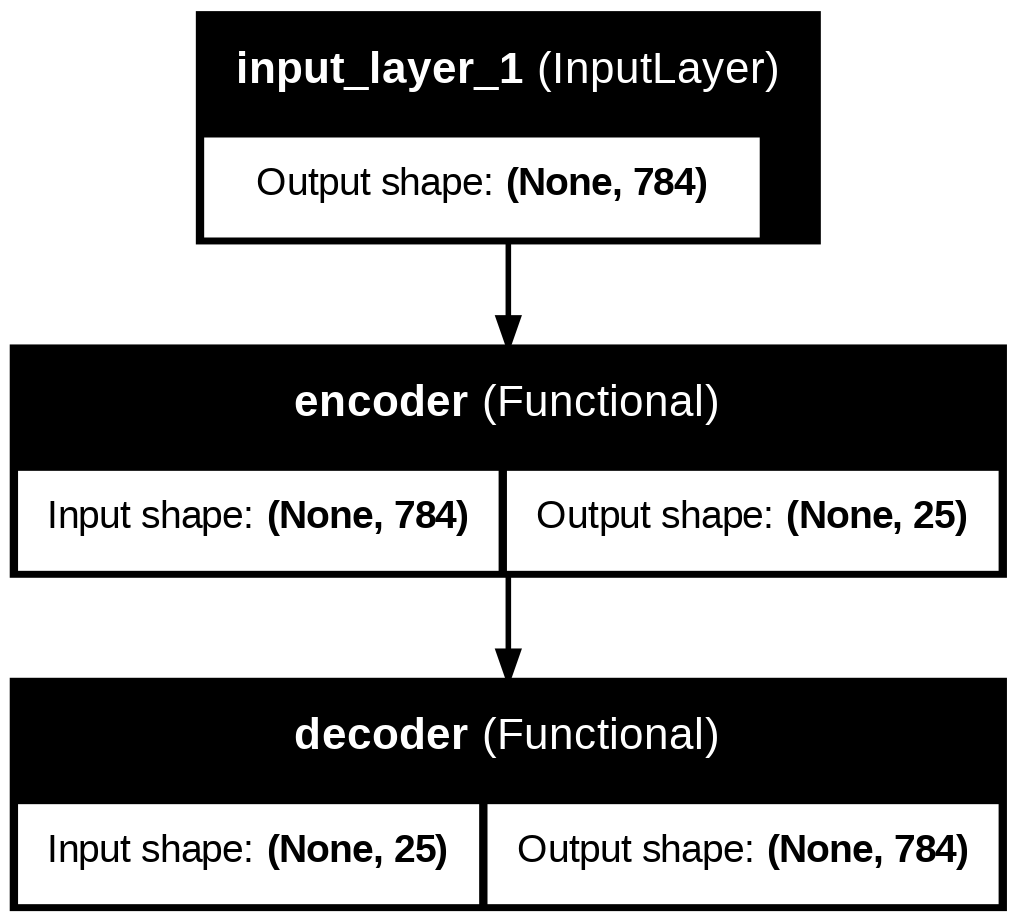

In [24]:
from tensorflow.keras.utils import plot_model

# Plot the architecture of the Autoencoder model
plot_model(autoencoder, to_file='autoencoder_architecture.png', show_shapes=True, show_layer_names=True)

# GMM


In [25]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train_normalized = scaler.fit_transform(x_train)
x_test_normalized = scaler.transform(x_test)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


In [26]:
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from sklearn.mixture import GaussianMixture

pca = PCA(n_components=50)  # Reduce to 50 dimensions
x_train_pca = pca.fit_transform(x_train_normalized)
x_test_pca = pca.transform(x_test_normalized)

In [27]:
lowest_bic = np.inf  # Initialize with a very large number
best_n = 1  # Initialize the best_n with an arbitrary value

for n in range(1, 6):  # Test 1 to 5 Gaussian components
    gmm = GaussianMixture(n_components=n, covariance_type='full', random_state=42)
    gmm.fit(x_train_pca)
    bic = gmm.bic(x_train_pca)
    print(f"GMM with {n} components -> BIC: {bic}")

    if bic < lowest_bic:
        lowest_bic = bic
        best_n = n

print(f"Optimal n_components: {best_n}")

# ------------------------------------------
# 4. Train Final GMM Model
# ------------------------------------------
gmm = GaussianMixture(n_components=best_n, covariance_type='full', random_state=42)
gmm.fit(x_train_pca)

GMM with 1 components -> BIC: 1600174.1646720343
GMM with 2 components -> BIC: 921581.1553695188
GMM with 3 components -> BIC: 969938.4060926044
GMM with 4 components -> BIC: 887385.9594244976
GMM with 5 components -> BIC: 781971.9738378554
Optimal n_components: 5


GaussianMixture(n_components=5, random_state=42)

In [28]:
# Calculate log-likelihood scores
log_likelihood_normal = gmm.score_samples(x_train_pca)
log_likelihood_anomaly = gmm.score_samples(x_test_pca)

In [29]:
# Set threshold (e.g., 5th percentile of normal data log-likelihood)
threshold_gmm = np.percentile(log_likelihood_normal, 95)
print(f"Anomaly detection threshold: {threshold_gmm:.2f}")

Anomaly detection threshold: -24.91


In [30]:
gmm_pred  = log_likelihood_anomaly < threshold_gmm
accuracy = np.sum(gmm_pred) / len(anomaly_indices)
print(f"# of detected anomalies: {np.sum(gmm_pred)} from {len(anomaly_indices)}")
print(f"accuracy: {accuracy:.2f}")

# of detected anomalies: 26 from 26
accuracy: 1.00


In [31]:
# Evaluate performance
accuracy_gmm, fpr_gmm = evaluate_performance(
    true_labels=np.ones(len(x_test)),  # All test samples are anomalies
    predictions=gmm_pred,
    normal_data_errors=log_likelihood_normal,
    threshold=threshold_gmm
)

In [32]:
print(f"# of detected anomalies: {np.sum(gmm_pred)} out of {len(anomaly_indices)}")
print(f"Accuracy: {accuracy_gmm:.2f}")
print(f"False Positive Rate: {fpr_gmm:.4f}")

# of detected anomalies: 26 out of 26
Accuracy: 1.00
False Positive Rate: 0.0500


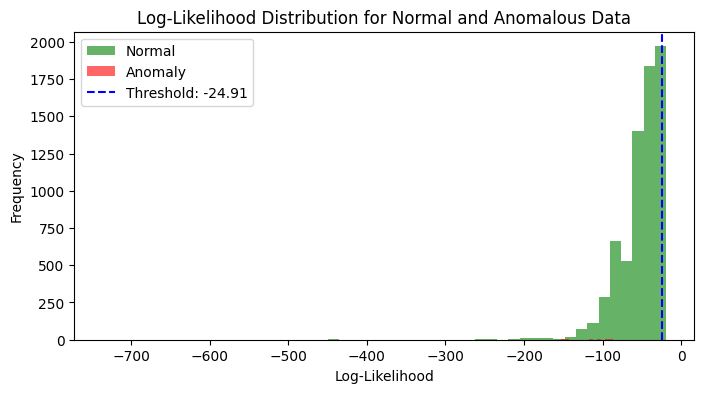

In [33]:
# Plot log-likelihood distribution
plt.figure(figsize=(8, 4))
plt.hist(log_likelihood_normal, bins=50, alpha=0.6, color='g', label='Normal')
plt.hist(log_likelihood_anomaly, bins=50, alpha=0.6, color='r', label='Anomaly')
plt.axvline(threshold_gmm, color='b', linestyle='--', label=f'Threshold: {threshold_gmm:.2f}')
plt.xlabel('Log-Likelihood')
plt.ylabel('Frequency')
plt.title('Log-Likelihood Distribution for Normal and Anomalous Data')
plt.legend()
plt.show()

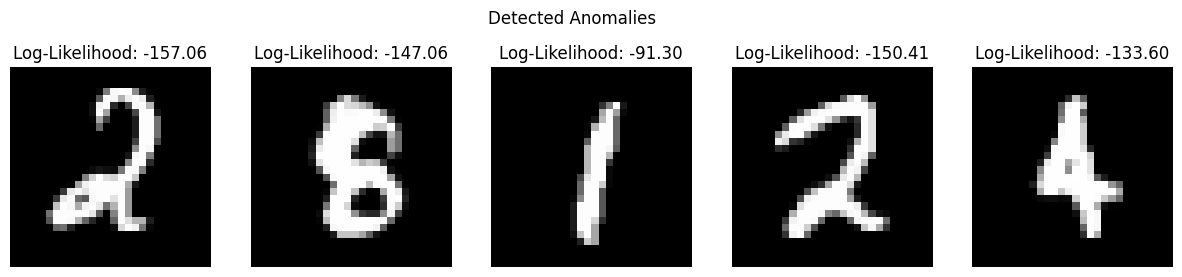

In [34]:
# Visualize detected anomalies
detected_indices = np.where(gmm_pred)[0]
plt.figure(figsize=(15, 3))
plt.suptitle('Detected Anomalies', y=1.02)
for i, idx in enumerate(detected_indices[:5]):
    plt.subplot(1, 5, i+1)
    plt.imshow(x_test.to_numpy()[idx].reshape(28, 28), cmap='gray')
    plt.title(f'Log-Likelihood: {log_likelihood_anomaly[idx]:.2f}')
    plt.axis('off')
plt.show()

# PCA

In [35]:


pca = PCA(n_components=50)
X_pca = pca.fit(x_train)

explained_variance = pca.explained_variance_ratio_.sum()
print(f"Varicance with {50} components: {explained_variance:.2f}")


Varicance with 50 components: 0.88


In [36]:
x_train_pca = pca.transform(x_train)
x_train_reconstructed = pca.inverse_transform(x_train_pca)
x_test_pca = pca.transform(x_test)
x_test_reconstructed = pca.inverse_transform(x_test_pca)


reconstruction_error_normal = np.mean((x_train - x_train_reconstructed) ** 2, axis=1)
reconstruction_error_anomaly = np.mean((x_test - x_test_reconstructed) ** 2, axis=1)

# Set threshold (e.g., 95th percentile of normal data errors)
threshold_pca = np.percentile(reconstruction_error_normal, 95)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


In [37]:
print(f"threshold for PCA is:{threshold_pca:.2f}")

threshold for PCA is:0.01


In [38]:
# Detect anomalies
pca_pred = reconstruction_error_anomaly > threshold_pca

In [39]:
# Evaluate performance
accuracy_pca, fpr_pca = evaluate_performance(
    true_labels=np.ones(len(x_test)),  # All test samples are anomalies
    predictions=pca_pred,
    normal_data_errors=reconstruction_error_normal,
    threshold=threshold_pca
)

## Final Comparison

In [40]:
print(f"Autoencoder Accuracy: {accuracy_autoencoder:.2f}")
print(f"Autoencoder False Positive Rate: {fpr_autoencoder:.4f}")
print(f"GMM Accuracy: {accuracy_gmm:.2f}")
print(f"GMM False Positive Rate: {fpr_gmm:.4f}")
print(f"PCA Accuracy: {accuracy_pca:.2f}")
print(f"PCA False Positive Rate: {fpr_pca:.4f}")

Autoencoder Accuracy: 1.00
Autoencoder False Positive Rate: 0.0301
GMM Accuracy: 1.00
GMM False Positive Rate: 0.0500
PCA Accuracy: 1.00
PCA False Positive Rate: 0.0500


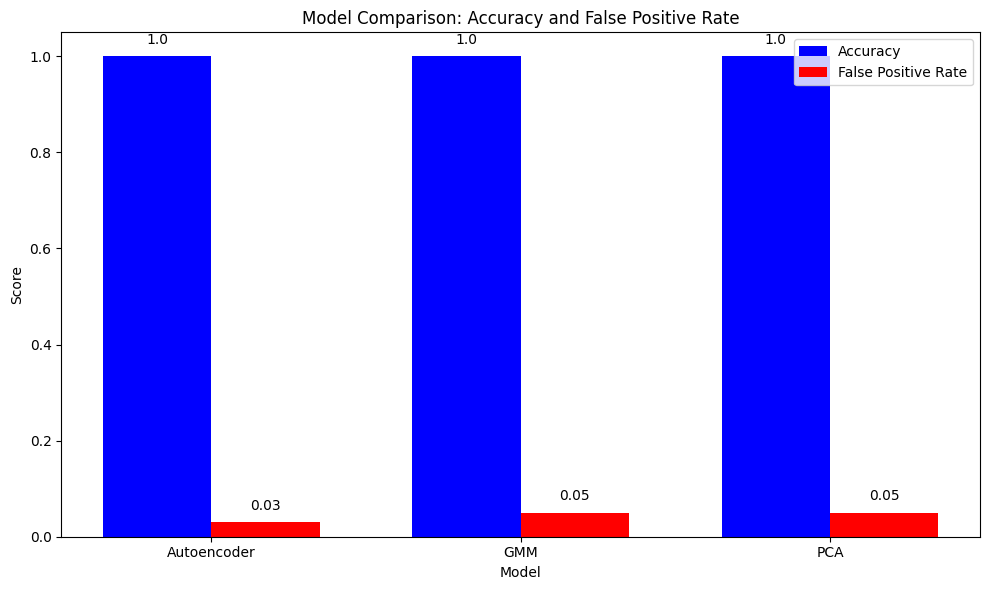

In [57]:
fig, ax = plt.subplots(figsize=(10, 6))

# X-axis labels (models)
models = ['Autoencoder', 'GMM', 'PCA']

# Accuracy and FPR values for each model
accuracy_values = [accuracy_autoencoder, accuracy_gmm, accuracy_pca]
fpr_values = [fpr_autoencoder, fpr_gmm, fpr_pca]

# Bar width
bar_width = 0.35

# X positions for the bars
index = np.arange(len(models))

# Create the bars for Accuracy
bar1 = ax.bar(index, accuracy_values, bar_width, label='Accuracy', color='b')

# Create the bars for FPR, slightly offset on the X-axis
bar2 = ax.bar(index + bar_width, fpr_values, bar_width, label='False Positive Rate', color='r')

# Adding labels, title, and custom x-axis tick labels
ax.set_xlabel('Model')
ax.set_ylabel('Score')
ax.set_title('Model Comparison: Accuracy and False Positive Rate')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(models)
ax.legend()

# Display the values on top of the bars
def add_values_on_bars(bars):
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, yval + 0.02, round(yval, 2), ha='center', va='bottom')

# Add values for accuracy and FPR bars
add_values_on_bars(bar1)
add_values_on_bars(bar2)

# Show the plot
plt.tight_layout()
plt.show()